In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import product
import math
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
import graphviz 

import ml_pipeline_lch as ml
import ml_explore as exp
import ml_modeling as md
import credit_util as crd

sns.set(style = "ticks", color_codes = True)
%matplotlib inline 

### Read and Pre-Process Data

#### Read Data

In [2]:
credit_df = ml.retrieve_data(filename = 'data/credit-data.csv', headers = True, set_ind = 0)

In [3]:
credit_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [4]:
# explore statistics of all columns
credit_df.describe().round(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.000,41016.000,41016.000,41016.000,41016.000,41016.000,33042.000,41016.000,41016.00,41016.000,41016.000,39979.000
mean,0.161,6.376,51.683,60623.824,0.589,331.458,6578.996,8.403,0.42,1.009,0.372,0.773
std,0.368,221.619,14.747,11.984,5.206,1296.110,13446.826,5.207,5.19,1.154,5.170,1.121
min,0.000,0.000,21.000,60601.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
25%,0.000,0.034,41.000,60618.000,0.000,0.176,3333.000,5.000,0.00,0.000,0.000,0.000
50%,0.000,0.190,51.000,60625.000,0.000,0.370,5250.000,8.000,0.00,1.000,0.000,0.000
75%,0.000,0.667,62.000,60629.000,0.000,0.866,8055.750,11.000,0.00,2.000,0.000,1.000
max,1.000,22000.000,109.000,60644.000,98.000,106885.000,1794060.000,56.000,98.00,32.000,98.000,13.000


In [5]:
# create quick reference for accessing columns
col_ref = ml.create_col_ref(credit_df)
col_ref

{'DebtRatio': 5,
 'MonthlyIncome': 6,
 'NumberOfDependents': 11,
 'NumberOfOpenCreditLinesAndLoans': 7,
 'NumberOfTime30-59DaysPastDueNotWorse': 4,
 'NumberOfTime60-89DaysPastDueNotWorse': 10,
 'NumberOfTimes90DaysLate': 8,
 'NumberRealEstateLoansOrLines': 9,
 'RevolvingUtilizationOfUnsecuredLines': 1,
 'SeriousDlqin2yrs': 0,
 'age': 2,
 'zipcode': 3}

In [6]:
# check column types
credit_df.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
zipcode                                   int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

#### Identify Outliers

In [7]:
  def remove_dramatic_outliers(df, outliers_df, max_min_df, col, threshold):
    outlier_values = list(max_min_df.loc[outliers_df[outliers_df[col] > threshold][col].index, col])
    df[~df[col].isin(outlier_values)]

In [8]:
maxes = ml.view_max_mins(credit_df, max = True)
maxes.tail()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.996,1.0,1.820415,90.0,60644.0,6.0,6530.920,39993.260,28.0,7.000,6.0,4.0,5.0
0.997,1.0,2.054715,91.0,60644.0,9.0,7480.875,45000.000,30.0,10.955,7.0,6.0,5.0
0.998,1.0,3.601156,92.0,60644.0,98.0,8896.110,58305.694,32.0,98.000,8.0,98.0,5.0
0.999,1.0,1760.280000,94.0,60644.0,98.0,11373.160,81840.551,35.0,98.000,10.0,98.0,6.0
1.000,1.0,22000.000000,109.0,60644.0,98.0,106885.000,1794060.000,56.0,98.000,32.0,98.0,13.0


In [9]:
likely_outliers_upper = ml.view_likely_outliers(credit_df)
likely_outliers_upper.tail()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.996,0.0,0.121875,0.011236,0.0,0.000000,0.075482,0.199810,0.037037,0.166667,0.000000,0.333333,0.000000
0.997,0.0,0.128707,0.011111,0.0,0.500000,0.145455,0.125190,0.071429,0.565000,0.166667,0.500000,0.000000
0.998,0.0,0.752630,0.010989,0.0,9.888889,0.189180,0.295682,0.066667,7.945687,0.142857,15.333333,0.000000
0.999,0.0,487.809672,0.021739,0.0,0.000000,0.278442,0.403646,0.093750,0.000000,0.250000,0.000000,0.200000
1.000,0.0,11.498012,0.159574,0.0,0.000000,8.398004,20.921407,0.600000,0.000000,2.200000,0.000000,1.166667


In [10]:
mins = ml.view_max_mins(credit_df, max = False)
mins

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.000,0.0,0.0,21.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.001,0.0,0.0,21.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.002,0.0,0.0,22.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.003,0.0,0.0,22.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.004,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.005,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.006,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.007,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.008,0.0,0.0,23.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.009,0.0,0.0,24.0,60601.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
likely_outliers_lower = ml.view_likely_outliers(credit_df, max = False)
likely_outliers_lower

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002,NaN,NaN,0.047619,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.003,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.004,NaN,NaN,0.045455,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.005,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.006,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.007,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.008,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.009,NaN,NaN,0.043478,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Revolving utilization of unsecured credit lines should be between 0 and 1
ml.remove_over_threshold(credit_df, col = "RevolvingUtilizationOfUnsecuredLines", value_cutoff = 1)


In [13]:
ml.remove_over_threshold(credit_df, 'DebtRatio', 0.999)

In [14]:
ml.print_null_freq(credit_df)

value                                 False  True 
variable                                          
DebtRatio                             40974     42
MonthlyIncome                         33042   7974
NumberOfDependents                    39979   1037
NumberOfOpenCreditLinesAndLoans       41016      0
NumberOfTime30-59DaysPastDueNotWorse  41016      0
NumberOfTime60-89DaysPastDueNotWorse  41016      0
NumberOfTimes90DaysLate               41016      0
NumberRealEstateLoansOrLines          41016      0
RevolvingUtilizationOfUnsecuredLines  39677   1339
SeriousDlqin2yrs                      41016      0
age                                   41016      0
zipcode                               41016      0


#### Fill Null Values

In [15]:
# fill null values  with basic 
ml.basic_fill_vals(credit_df, "NumberOfDependents", method = "zeros")

In [16]:
ml.basic_fill_vals(credit_df, "MonthlyIncome", method = "mean")

In [17]:
ml.basic_fill_vals(credit_df, "RevolvingUtilizationOfUnsecuredLines", method = "mean")

In [18]:
ml.basic_fill_vals(credit_df, "DebtRatio", method = "mean")

In [19]:
ml.print_null_freq(credit_df)

value                                 False
variable                                   
DebtRatio                             41016
MonthlyIncome                         41016
NumberOfDependents                    41016
NumberOfOpenCreditLinesAndLoans       41016
NumberOfTime30-59DaysPastDueNotWorse  41016
NumberOfTime60-89DaysPastDueNotWorse  41016
NumberOfTimes90DaysLate               41016
NumberRealEstateLoansOrLines          41016
RevolvingUtilizationOfUnsecuredLines  41016
SeriousDlqin2yrs                      41016
age                                   41016
zipcode                               41016


### Explore Data

In [20]:
explore_df = credit_df[credit_df.columns]

#### Feature Distribution

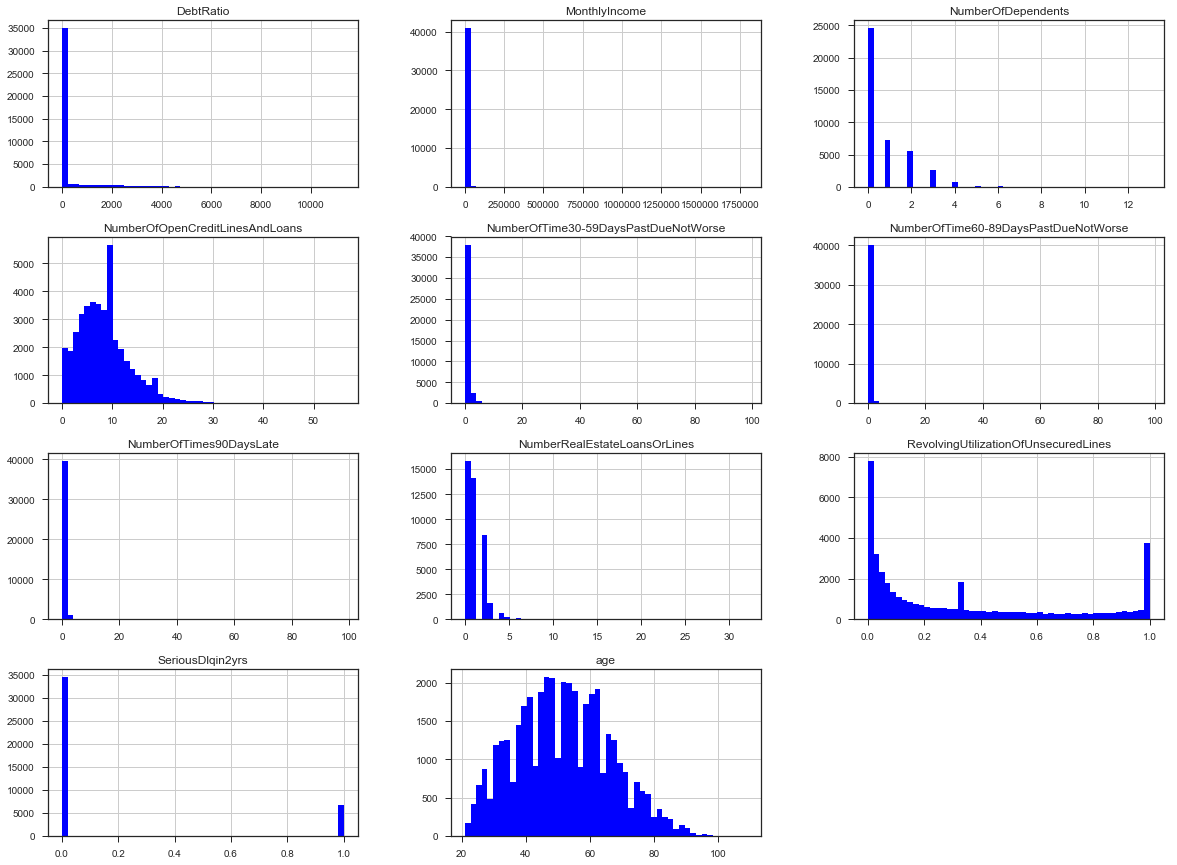

In [21]:
exp.view_dist(explore_df, ["zipcode"])

### Feature Correlation 

#### Pearson Correlation

There appears to be a significant amount of correlation between number of times 30-59 days late, the number of times 60-89 days late, and number of times 90+ days late, that is, a sample who has made a late payment in the 30-60 day window is likely to have also made late payments in the 60-90 day window and 90+ days after due date. As could be expected, the number of real estate loans or lines of credit is correlated with the total number of lines of credit or loans held by a sample. There appears to be relatively low correlation between other predictors.

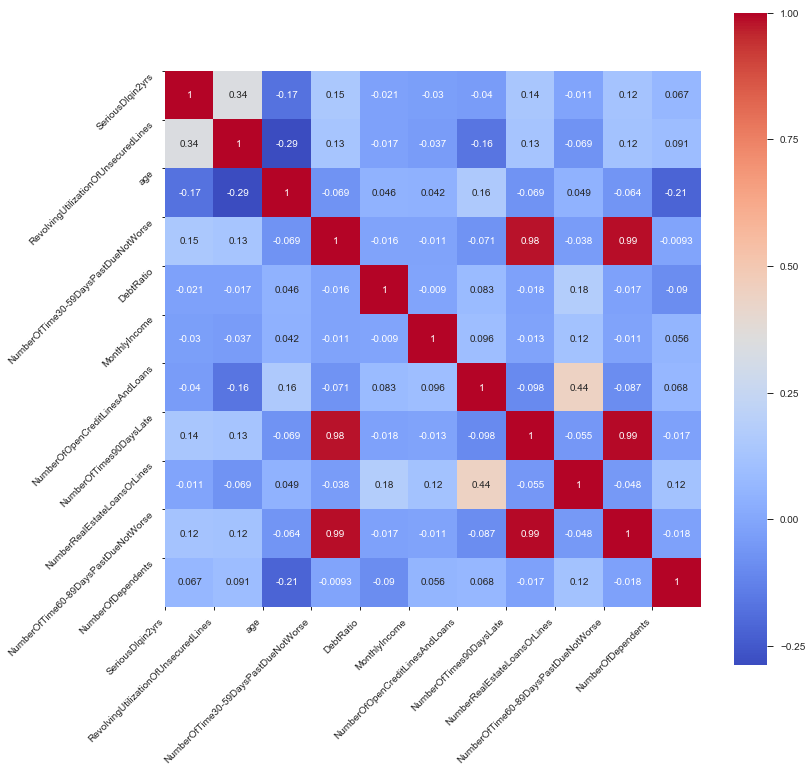

In [22]:
exp.check_corr(explore_df, geo_columns = ["zipcode"])

### Generation of Features/ Predictors and Additional Exploration

#### Discretization of Non-Categorical Variables

In [23]:
exp.discretize_cols(explore_df, ['zipcode'], 7)
explore_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,RevolvingUtilizationOfUnsecuredLines_bin,age_bin,NumberOfTime30-59DaysPastDueNotWorse_bin,DebtRatio_bin,MonthlyIncome_bin,NumberOfOpenCreditLinesAndLoans_bin,NumberOfTimes90DaysLate_bin,NumberRealEstateLoansOrLines_bin,NumberOfTime60-89DaysPastDueNotWorse_bin,NumberOfDependents_bin
PersonID,,,,,,,,,,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,...,"(0.9, 1.0]","[50.0, 60.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,...,"(0.4, 0.6]","[70.0, 80.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,...,"(-0.001, 0.1]","[50.0, 60.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,...,"(0.9, 1.0]","[50.0, 60.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(8.0, 16.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]"
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,...,"(-0.001, 0.1]","[41.0, 50.0)","(-0.1, 14.0]","(-11.0, 1617.0]","(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(2.0, 4.0]"


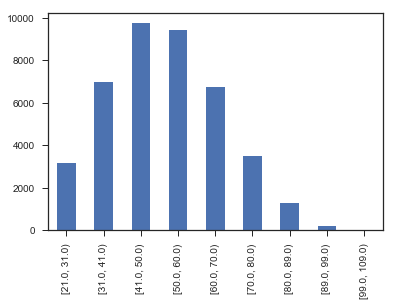

In [24]:
explore_df["age_bin"].value_counts().sort_index().plot(kind='bar')
plt.show()

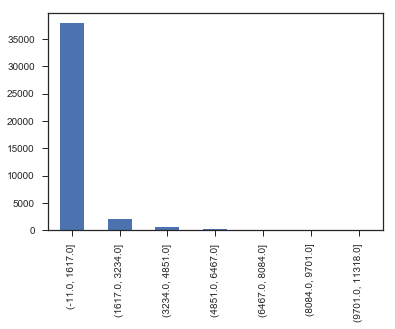

In [25]:
explore_df["DebtRatio_bin"].value_counts().sort_index().plot(kind='bar')
plt.show()

#### Inter-Variable Correlation

In [26]:
# observe distributions and correlations of features 
def plot_corr(df, geo_columns, color_category):
    non_categoricals = isolate_noncategoricals(df, ret_categoricals = False, geo_cols = geo_columns)
    plot_list = non_categoricals + [color_category]
    corr = sns.pairplot(df[plot_list], hue = color_category, palette = "Set2")

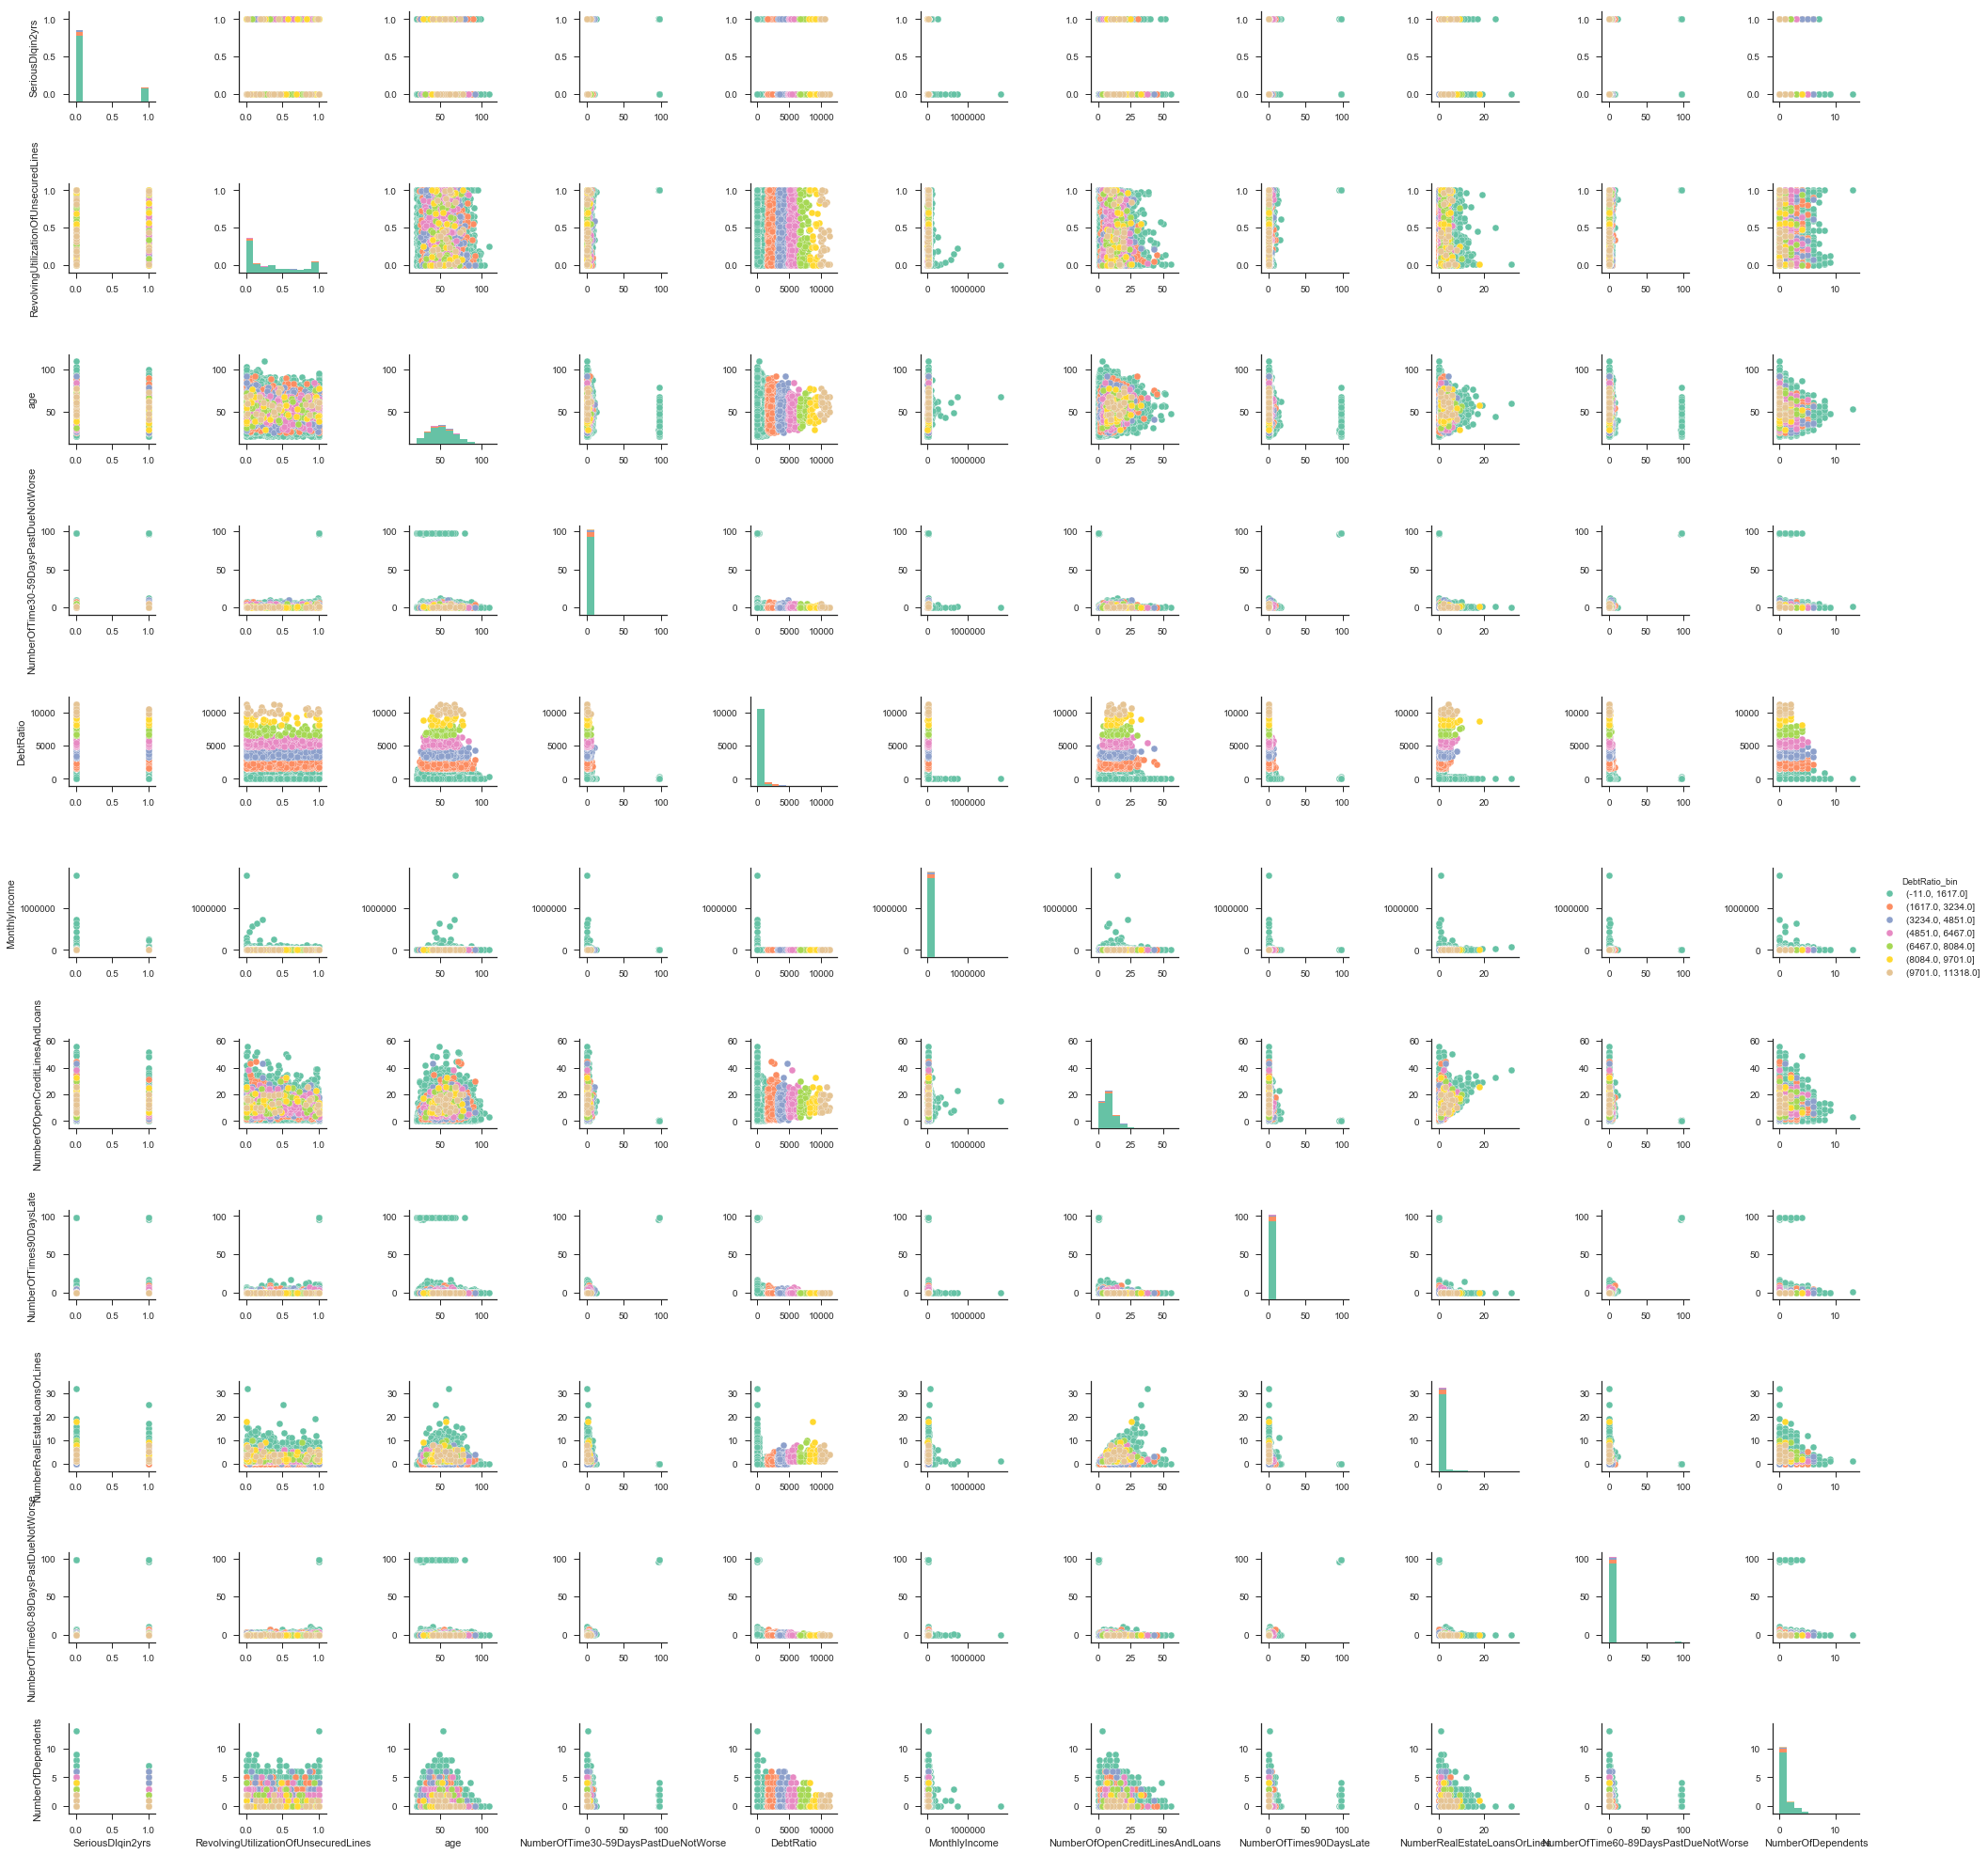

In [27]:
exp.plot_corr(explore_df, geo_columns = ["zipcode"], color_category = "DebtRatio_bin")

#### Debt Ratio and Credit Utilization Breakdown by Age & Credit Utiliziation Breakdown by Debt Ratio 

Age alone does not appear to be a predicting debt ratio--each grouping of debt ratio appears to be spread fairly evenly across age groups, with most samples concentrated around median debt ratio value just below 0.4%. 

Though there appears to be a slight decline in utilization of credit in older age groups (80 years or older), there are far fewer samples in these age group, which could be influencing results with downward bias. Somewhat surprisingly, a higher debt ratio does not appear to be correlated with higher revolving credit utilization.


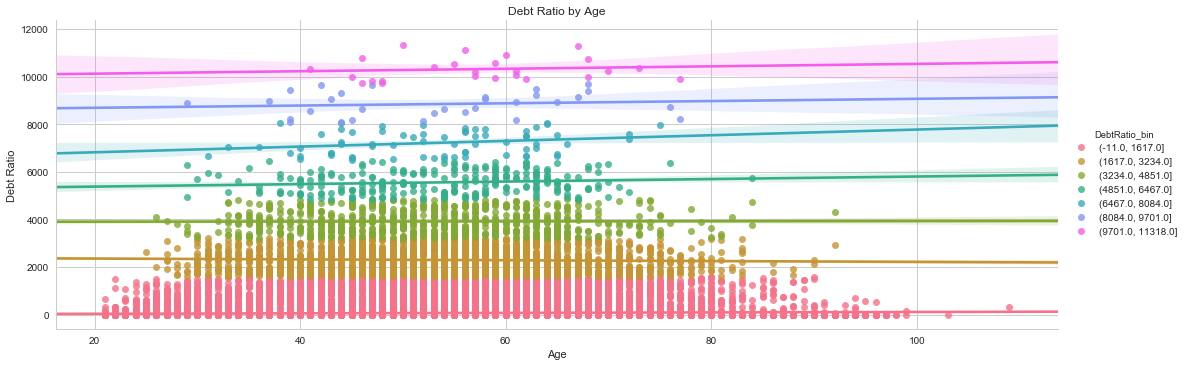

In [28]:
exp.plot_relationship(explore_df, feature_x = 'age', xlabel = 'Age', feature_y = 'DebtRatio', ylabel = 'Debt Ratio', color_cat = 'DebtRatio_bin')

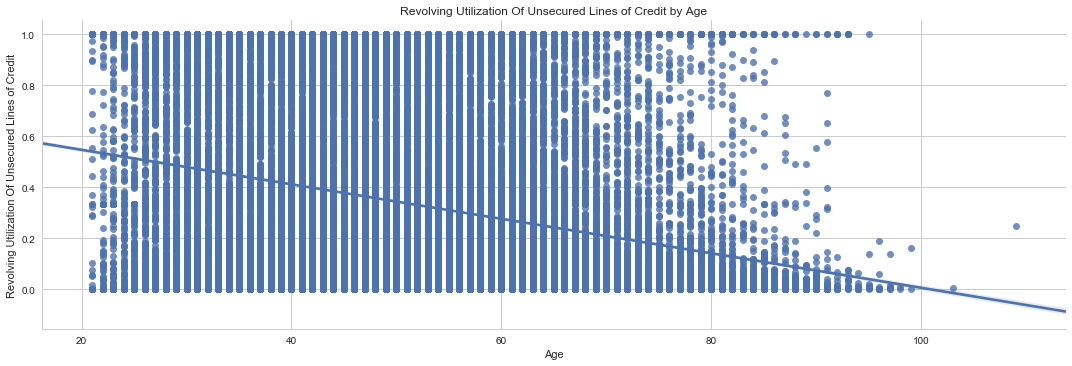

In [29]:
exp.plot_relationship(explore_df, feature_x = 'age', xlabel = 'Age', feature_y = 'RevolvingUtilizationOfUnsecuredLines', ylabel = 'Revolving Utilization Of Unsecured Lines of Credit')

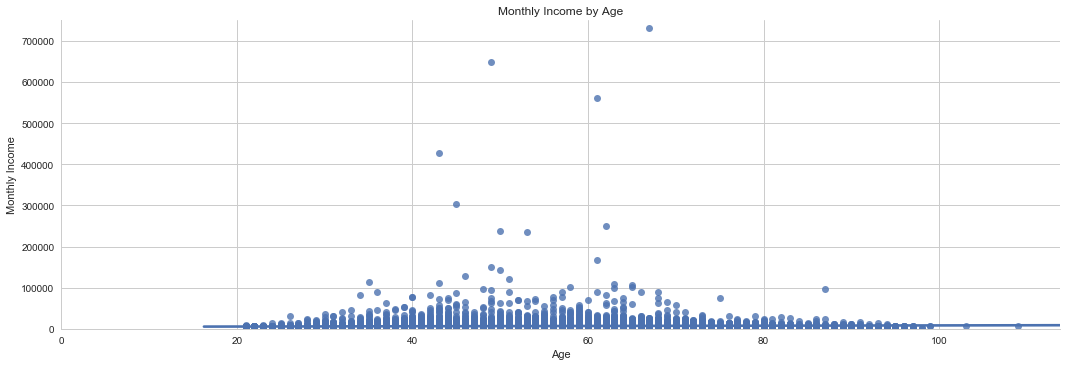

In [30]:
exp.plot_relationship(explore_df, feature_x = 'age', xlabel = 'Age', feature_y = 'MonthlyIncome', ylabel = 'Monthly Income', xlimit = (0, None), ylimit = (0, 750000))

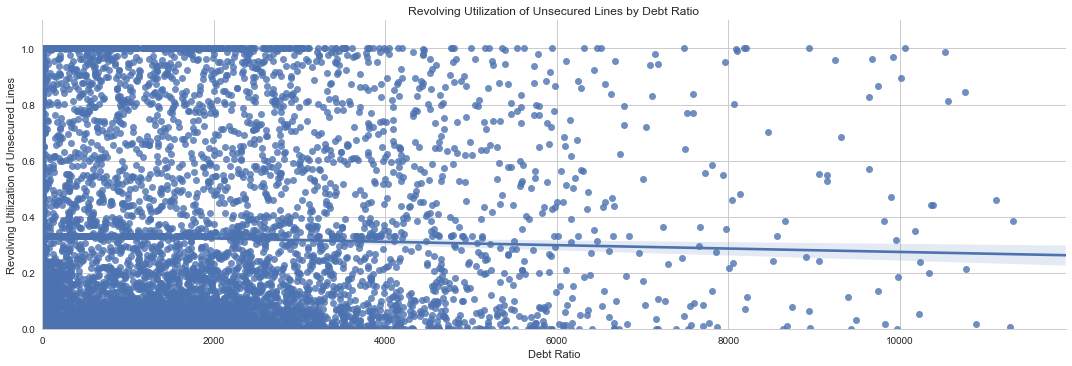

In [31]:
exp.plot_relationship(explore_df, feature_x = 'DebtRatio', xlabel = 'Debt Ratio', feature_y = 'RevolvingUtilizationOfUnsecuredLines', ylabel = 'Revolving Utilization of Unsecured Lines', xlimit = (0, None), ylimit = (0, 1.1))

#### Payment Delinquency Across Age Groups 

In [32]:
exp.eval_ratios(explore_df, include_cols = ['age_bin', 'SeriousDlqin2yrs'], category_cols = ['age_bin'], method = "sum", pct = True)

,SeriousDlqin2yrs,SeriousDlqin2yrs Percentage
age_bin,,
"[21.0, 31.0)",838,12.658610
"[31.0, 41.0)",1590,24.018127
"[41.0, 50.0)",1907,28.806647
"[50.0, 60.0)",1394,21.057402
"[60.0, 70.0)",608,9.184290
"[70.0, 80.0)",200,3.021148
"[80.0, 89.0)",72,1.087613
"[89.0, 99.0)",11,0.166163
"[99.0, 109.0)",0,0.000000


In [33]:
payment_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
crd.payment_grid(explore_df, focus_cols = payment_cols, group_col = 'age_bin')

,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTime30-59DaysPastDueNotWorse Percentage,NumberOfTimes90DaysLate,NumberOfTimes90DaysLate Percentage,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorse Percentage
age_bin,,,,,,
"[21.0, 31.0)",6660,27.557100,6523,37.902382,6205,40.712552
"[31.0, 41.0)",4355,18.019695,3272,19.012202,2674,17.544781
"[41.0, 50.0)",5464,22.608408,3245,18.855317,2708,17.767863
"[50.0, 60.0)",4820,19.943727,2841,16.507844,2450,16.075061
"[60.0, 70.0)",2042,8.449189,1029,5.979082,941,6.174136
"[70.0, 80.0)",643,2.660543,254,1.475886,206,1.351617
"[80.0, 89.0)",156,0.645482,36,0.209181,47,0.308379
"[89.0, 99.0)",28,0.115856,10,0.058106,10,0.065612
"[99.0, 109.0)",0,0.000000,0,0.000000,0,0.000000


### Open Credit Lines and Loans Breakdown by Debt Ratio, Age, and Zip Code

For the six zip codes included in sample, the median number of open credit lines majority of persons in the 31-79 age ran is 7-8, with a temporary jump in all zip codes to 9 in the 50-59 decade. only a portion of  samples in age ranges 41-69 had significantly more open lines of credit than other groups, with the vast majority in the 50-59 range. 

#### Number of Samples by Zip Code

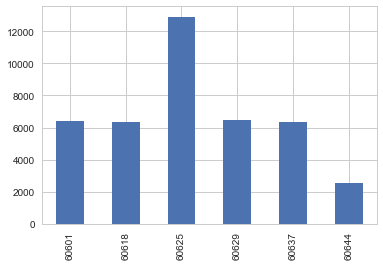

In [34]:
explore_df["zipcode"].value_counts().sort_index().plot(kind='bar')
plt.show()

#### Median Open Credit Lines and Loans by Debt Ratio Bracket Across Zip Codes

In [35]:
zip_open_credits_median = exp.feature_by_geo(explore_df, geo = 'zipcode', expl_var = ["DebtRatio_bin"], num_var = "NumberOfOpenCreditLinesAndLoans")
zip_open_credits_median

DebtRatio_bin,"(-11.0, 1617.0]","(1617.0, 3234.0]","(3234.0, 4851.0]","(4851.0, 6467.0]","(6467.0, 8084.0]","(8084.0, 9701.0]","(9701.0, 11318.0]"
zipcode,,,,,,,
60601,8.0,9.0,9.5,10.5,11.0,15.0,10.0
60618,7.0,8.0,9.0,11.0,15.0,10.0,15.0
60625,7.0,8.0,9.0,10.0,13.0,11.0,17.0
60629,7.0,8.0,10.0,12.0,11.5,25.0,18.0
60637,7.0,8.0,11.0,11.0,14.0,13.0,12.0
60644,8.0,9.0,10.0,9.0,12.0,18.0,7.0


#### Count of Open Credit Lines and Loans by Debt Ratio Bracket Across Zip Codes

In [36]:
zip_open_credits_count = exp.feature_by_geo(explore_df, 'zipcode', ["DebtRatio_bin"], "NumberOfOpenCreditLinesAndLoans", method = "count")
zip_open_credits_count.transform(lambda x: x/x.sum())

DebtRatio_bin,"(-11.0, 1617.0]","(1617.0, 3234.0]","(3234.0, 4851.0]","(4851.0, 6467.0]","(6467.0, 8084.0]","(8084.0, 9701.0]","(9701.0, 11318.0]"
zipcode,,,,,,,
60601,0.156486,0.163305,0.142857,0.170732,0.130435,0.200000,0.20
60618,0.154003,0.162344,0.152661,0.134146,0.159420,0.200000,0.24
60625,0.316063,0.297791,0.282913,0.329268,0.318841,0.333333,0.24
60629,0.157332,0.159462,0.172269,0.134146,0.173913,0.066667,0.08
60637,0.154240,0.156580,0.176471,0.170732,0.188406,0.133333,0.20
60644,0.061876,0.060519,0.072829,0.060976,0.028986,0.066667,0.04


#### Median Open Credit Lines and Loans by Age Group Across Zip Codes

In [37]:
zip_open_credits_median_age = exp.feature_by_geo(explore_df, 'zipcode', ["age_bin"], "NumberOfOpenCreditLinesAndLoans", method = "median")
zip_open_credits_median_age

age_bin,"[21.0, 31.0)","[31.0, 41.0)","[41.0, 50.0)","[50.0, 60.0)","[60.0, 70.0)","[70.0, 80.0)","[80.0, 89.0)","[89.0, 99.0)","[99.0, 109.0)"
zipcode,,,,,,,,,
60601,4.0,7.0,8.0,9.0,9.0,8.0,7.0,5.5,6
60618,4.0,7.0,8.0,9.0,8.0,8.0,6.0,5.0,
60625,4.0,7.0,8.0,9.0,8.0,7.0,6.0,4.0,
60629,4.0,7.0,8.0,9.0,9.0,8.0,6.0,5.5,3
60637,4.0,7.0,8.0,9.0,9.0,8.0,6.0,4.0,
60644,4.0,7.0,8.0,9.0,9.0,7.0,6.0,4.0,


#### Count of Open Credit Lines and Loans by Age Group Across Zip Codes

In [38]:
zip_open_credits_count_age = exp.feature_by_geo(explore_df, 'zipcode', ["age_bin"], "NumberOfOpenCreditLinesAndLoans", method = "count")
zip_open_credits_count_age

age_bin,"[21.0, 31.0)","[31.0, 41.0)","[41.0, 50.0)","[50.0, 60.0)","[60.0, 70.0)","[70.0, 80.0)","[80.0, 89.0)","[89.0, 99.0)","[99.0, 109.0)"
zipcode,,,,,,,,,
60601,506.0,1058.0,1563.0,1467.0,1078.0,527.0,195.0,32.0,1
60618,491.0,1074.0,1483.0,1500.0,1042.0,523.0,194.0,25.0,
60625,956.0,2218.0,3090.0,2952.0,2103.0,1123.0,406.0,56.0,
60629,528.0,1137.0,1492.0,1458.0,1085.0,531.0,197.0,30.0,1
60637,514.0,1056.0,1548.0,1476.0,998.0,526.0,207.0,29.0,
60644,168.0,414.0,581.0,568.0,444.0,259.0,94.0,12.0,


#### Dummy Variable Creation

In [39]:
to_dummy = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']
dummy_flags = ['NumberOfTimes', 'NumberOfTime', 'NumberOf']

In [40]:
exp.create_binary_vars(explore_df, to_dummy, dummy_flags)

In [41]:
explore_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,MonthlyIncome_bin,NumberOfOpenCreditLinesAndLoans_bin,NumberOfTimes90DaysLate_bin,NumberRealEstateLoansOrLines_bin,NumberOfTime60-89DaysPastDueNotWorse_bin,NumberOfDependents_bin,tf_30-59DaysPastDueNotWorse,tf_90DaysLate,tf_60-89DaysPastDueNotWorse,tf_Dependents
PersonID,,,,,,,,,,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,...,"(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]",False,False,False,False
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,...,"(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]",False,False,False,False
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,...,"(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]",False,False,False,False
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,...,"(-1794.0, 256294.0]","(8.0, 16.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(-0.0, 2.0]",True,False,False,False
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,...,"(-1794.0, 256294.0]","(-0.1, 8.0]","(-0.1, 14.0]","(-0.0, 5.0]","(-0.1, 14.0]","(2.0, 4.0]",False,False,False,True


#### Monthly Income by Number of Dependents 

In most zip codes, samples with dependents have monthly income \$1200-\$1500 higher than those without. In zip code 60644, this difference i over \$2000.  

In [42]:
crd.standardized_comparison(explore_df, primary_cols = ['tf_Dependents', 'MonthlyIncome'], group_cols = ['tf_Dependents'])

,MonthlyIncome
tf_Dependents,
False,6040.888301
True,7380.474027


In [43]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_Dependents', group_cols = ['zipcode']).reset_index().set_index('zipcode')

,tf_Dependents,MonthlyIncome
zipcode,,
60601,False,6401.454290
60601,True,7566.531990
60618,False,5869.699251
60618,True,7323.516632
60625,False,6020.927326
60625,True,7250.389672
60629,False,5965.944077
60629,True,7229.924780
60637,False,5897.377481


#### Delinquent Payments by Montly Income

There appears to be about a \$300 difference in monthly income between samples who heave made a payment between 30 and 59 days late in the last two years and those who did not make late payments, but a \$1200-\$1500 difference between samples who have made payments more than 60 days late. Zip code 60644 is the exception, with differences in monthly income between samples making late payments and those who made none in the multiple thousands of dollars.

In [44]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_30-59DaysPastDueNotWorse', group_cols = ['zipcode'])

MonthlyIncome
zipcode tf_30-59DaysPastDueNotWorse               
60601   False                          7020.914074
        True                           6242.160433
60618   False                          6529.893904
        True                           6113.693693
60625   False                          6528.243545
        True                           6486.258999
60629   False                          6509.637936
        True                           6284.018041
60637   False                          6499.673437
        True                           6148.891590
60644   False                          7180.791795
        True                           6867.081042

In [45]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_60-89DaysPastDueNotWorse', group_cols = ['zipcode'])

MonthlyIncome
zipcode tf_60-89DaysPastDueNotWorse               
60601   False                          6975.874549
        True                           5654.738101
60618   False                          6500.585771
        True                           5740.384502
60625   False                          6584.857152
        True                           5710.592244
60629   False                          6539.813955
        True                           5599.201596
60637   False                          6490.887094
        True                           5724.071473
60644   False                          6925.956655
        True                          14689.428023

In [46]:
crd.standardized_comparison(explore_df, primary_cols = ['zipcode', 'MonthlyIncome'], insert_col = 'tf_90DaysLate', group_cols = ['zipcode'])

MonthlyIncome
zipcode tf_90DaysLate               
60601   False            6999.580432
        True             5456.642314
60618   False            6568.044619
        True             5215.087232
60625   False            6631.600963
        True             5334.054181
60629   False            6573.623587
        True             5311.301352
60637   False            6532.663113
        True             5357.285538
60644   False            7222.861210
        True             4881.810400

### Build and Evaluate Classifier

Using the sklearn decision tree, I built and tested 108 versions of a decision tree model with varying parameters. I used the accuracy score for evaluation (as noted in assignment instructions), and identified the importance of each feature for the most accurate model. Finally, I created a graphic of the most accurate decision tree model.

#### Separate Training and Test Data

In [47]:
x_train, x_test, y_train, y_test = md.split_data(credit_df, outcome_var = "SeriousDlqin2yrs", geo_columns = ['zipcode'], test_size = 0.25)

In [48]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(30762, 10)
(30762,)
(10254, 10)
(10254,)


#### Build and Test Decision Tree Models

In [49]:
# parameters for looping sourced from example at https://github.com/rayidghani/magicloops/blob/master/mlfunctions.py
dt_params = {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100], 'max_features': [None, 'sqrt','log2'],'min_samples_split': [2,5,10]}

In [50]:
dt_results = md.loop_dt(dt_params, training_predictors = x_train, testing_predictors = x_test, training_outcome = y_train, testing_outcome = y_test)

In [51]:
dt_results_ordered = dt_results.sort_values('test_acc', ascending = False)
dt_results_ordered.head(20)

,criterion,max_depth,max_features,min_samples_split,test_acc,train_acc
65,entropy,5,None,10,0.876243,0.874098
64,entropy,5,None,5,0.876243,0.874098
63,entropy,5,None,2,0.876243,0.874098
10,gini,5,None,5,0.875366,0.874586
9,gini,5,None,2,0.875366,0.874586
11,gini,5,None,10,0.875366,0.874586
14,gini,5,sqrt,10,0.874586,0.873545
66,entropy,5,sqrt,2,0.873123,0.874065
17,gini,5,log2,10,0.872147,0.871822
15,gini,5,log2,2,0.872050,0.871465


In [52]:
dt_results_ordered.tail(20)

,criterion,max_depth,max_features,min_samples_split,test_acc,train_acc
47,gini,100,None,10,0.825434,0.949321
49,gini,100,sqrt,5,0.824946,0.964989
97,entropy,50,log2,5,0.823288,0.968208
103,entropy,100,sqrt,5,0.822898,0.968923
100,entropy,100,None,5,0.821728,0.979163
102,entropy,100,sqrt,2,0.821045,0.999610
46,gini,100,None,5,0.820753,0.974677
96,entropy,50,log2,2,0.820655,0.999610
37,gini,50,None,5,0.820363,0.974612
42,gini,50,log2,2,0.819680,0.999610


In [53]:
dec_tree = md.create_best_tree(accuracy_df = dt_results, training_predictors = x_train, training_outcome = y_train)

In [54]:
md.feature_importance_ranking(dec_tree, training_predictors = x_train)

,feature_importance
NumberOfTimes90DaysLate,0.490931
RevolvingUtilizationOfUnsecuredLines,0.269035
NumberOfTime30-59DaysPastDueNotWorse,0.145145
NumberOfTime60-89DaysPastDueNotWorse,0.072319
age,0.011574
DebtRatio,0.005009
MonthlyIncome,0.002236
NumberRealEstateLoansOrLines,0.001880
NumberOfOpenCreditLinesAndLoans,0.001053
NumberOfDependents,0.000817


#### Decision Tree Visual

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/tree/export.py:399: DeprecationWarning: out_file can be set to None starting from 0.18. This will be the default in 0.20.
  DeprecationWarning)


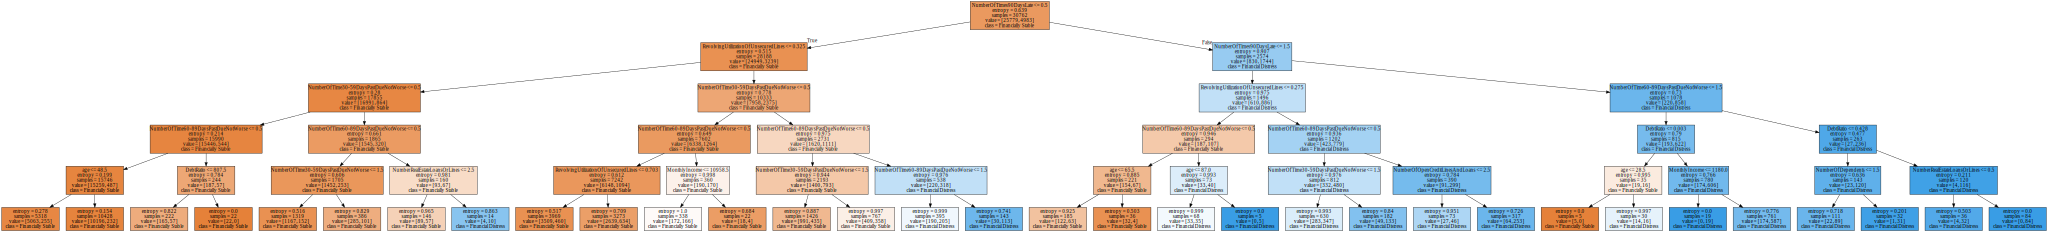

In [55]:
md.visualize_best_tree(dec_tree, training_predictors = x_train)